Remains the same methods, but used mimic data, no info about real employee KPI analysis is here.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from faker import Faker

In [2]:
path = r"C:\Users\Yijia Wang\Desktop\Open-House-Analysis\Data\July_2025\raw_data\anonymized_data.csv"
df = pd.read_csv(path)
# print("column names：")
# for col in df.columns:
#     print(f"- {col}")

In [3]:
# Only keep finished projects
df = df[df['Status'] == 'Finished'].copy()

In [4]:
# === Step 2: clean column names to remove extra spaces ===
df.columns = df.columns.str.strip().str.replace(':', '').str.replace('*', '').str.replace(' ', '_')

In [5]:
df = df.rename(columns={'Project_Manager': 'FS'})  

In [6]:
# === Step 3: clean date ===
date_fields = [
    'Make_Ready_Created_Date', 'Projected_Start_Date', 
    'Actual_Construction_Start_Date', 'Projected_Completion_Date', 
    'Actual_Confirm_Construction_Completion', 'Move_in_date'
]

for col in date_fields:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [7]:
# === Step 4: feature creation:add KPI columns ===
df['Month'] = df['Make_Ready_Created_Date'].dt.to_period('M')
df['Start_Delay'] = (df['Actual_Construction_Start_Date'] - df['Projected_Start_Date']).dt.days
df['Completion_Delay'] = (df['Actual_Confirm_Construction_Completion'] - df['Projected_Completion_Date']).dt.days
df['ACCC_to_Movein'] = (df['Move_in_date'] - df['Actual_Confirm_Construction_Completion']).dt.days

In [8]:
# === Step 5: make it to a long table ===
df_long = df.melt(
    id_vars=[
        'QRSerial', 'Month',
        'Start_Delay', 'Completion_Delay', 'ACCC_to_Movein',
        'MO_to_Create_MR', 'PCD_to_ACSD', 'PCD_to_ACCC',
        'Total_Actual_Budget_Cost', 'Status'
    ],
    value_vars=['PC', 'FM', 'CM', 'FS'],
    var_name='Role', value_name='Person'
)

In [9]:
# if name is missing, drop the row
df_long = df_long.dropna(subset=['Person'])

In [10]:
# === Step 6: summarize everyone's performance by month ===
performance = df_long.groupby(['Month', 'Role', 'Person']).agg({
    'QRSerial': 'count',
    'Start_Delay': 'mean',
    'Completion_Delay': 'mean',
    'ACCC_to_Movein': 'mean',
    'MO_to_Create_MR': 'mean',
    'PCD_to_ACSD': 'mean',
    'PCD_to_ACCC': 'mean',
    'Total_Actual_Budget_Cost': 'mean'
}).rename(columns={
    'QRSerial': 'Project_Count',
    'Start_Delay': 'Avg_Start_Delay',
    'Completion_Delay': 'Avg_Completion_Delay',
    'ACCC_to_Movein': 'Avg_ACCC_to_Movein',
    'MO_to_Create_MR': 'Avg_MO_to_MR',
    'PCD_to_ACSD': 'Avg_PCD_to_ACSD',
    'PCD_to_ACCC': 'Avg_PCD_to_ACCC',
    'Total_Actual_Budget_Cost': 'Avg_Budget'
}).reset_index()

In [11]:
# === Step 7 Pre: deal with missing before modeling ===
score_features = [
    'Avg_Start_Delay',
    'Avg_Completion_Delay',
    'Avg_ACCC_to_Movein',
    'Avg_MO_to_MR',
    'Avg_PCD_to_ACSD',
    'Avg_PCD_to_ACCC',
    'Avg_Budget',
]

# check count of missing values and calculate missing rate
missing_summary = performance[score_features].isna().sum().to_frame(name='Missing Count')
missing_summary['Total Count'] = len(performance)
missing_summary['Missing Rate (%)'] = (missing_summary['Missing Count'] / missing_summary['Total Count']) * 100

# rank with missing rate
missing_summary = missing_summary.sort_values(by='Missing Rate (%)', ascending=False)

print(missing_summary)

                      Missing Count  Total Count  Missing Rate (%)
Avg_ACCC_to_Movein              284         1627         17.455439
Avg_MO_to_MR                     39         1627          2.397050
Avg_Completion_Delay             33         1627          2.028273
Avg_PCD_to_ACCC                  33         1627          2.028273
Avg_PCD_to_ACSD                  18         1627          1.106331
Avg_Start_Delay                   9         1627          0.553165
Avg_Budget                        0         1627          0.000000


In [12]:
# delete any rows with missing values in score features
performance = performance.dropna(subset=score_features).copy()

In [13]:
# Let's check again
missing_summary = performance[score_features].isna().sum().to_frame(name='Missing Count')
missing_summary['Total Count'] = len(performance)
missing_summary['Missing Rate (%)'] = (missing_summary['Missing Count'] / missing_summary['Total Count']) * 100
missing_summary = missing_summary.sort_values(by='Missing Rate (%)', ascending=False)
print(missing_summary)

                      Missing Count  Total Count  Missing Rate (%)
Avg_Start_Delay                   0         1341               0.0
Avg_Completion_Delay              0         1341               0.0
Avg_ACCC_to_Movein                0         1341               0.0
Avg_MO_to_MR                      0         1341               0.0
Avg_PCD_to_ACSD                   0         1341               0.0
Avg_PCD_to_ACCC                   0         1341               0.0
Avg_Budget                        0         1341               0.0


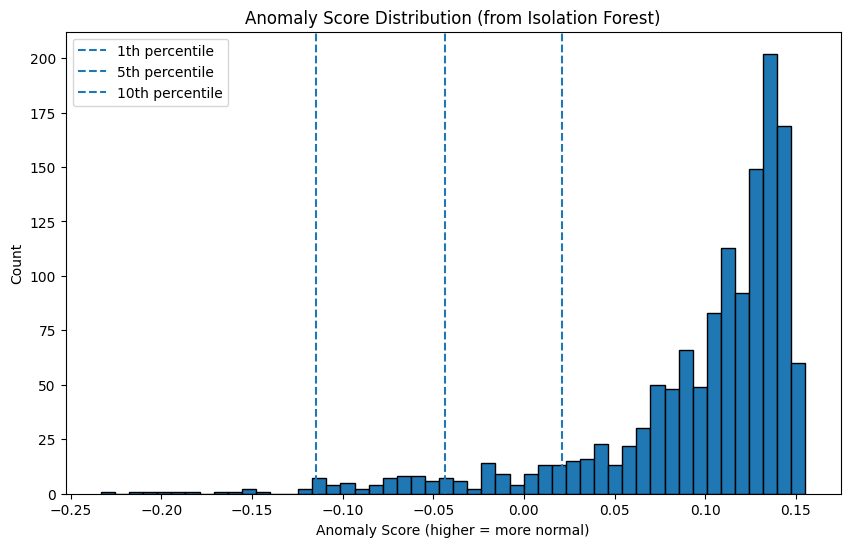

In [14]:
features = performance[score_features]

# model using default contamination
model = IsolationForest(contamination='auto', random_state=42)
model.fit(features)

# get anomaly scores
scores = model.decision_function(features)  # smaller values indicate more anomalous behavior
performance['Anomaly_Score'] = scores

plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, edgecolor='k')
plt.title("Anomaly Score Distribution (from Isolation Forest)")
plt.xlabel("Anomaly Score (higher = more normal)")
plt.ylabel("Count")

# add vertical lines for percentiles
for pct in [1, 5, 10]:
    threshold = np.percentile(scores, pct)
    plt.axvline(threshold, linestyle='--', label=f'{pct}th percentile')

plt.legend()
plt.show()

In [15]:
# === Step 7: detect abnormal behavior ===
model = IsolationForest(contamination=0.1, random_state=42) # let's use 10%, model think 10% of the data is anomalous
performance['Anomaly_Score'] = model.fit_predict(features)
performance['Needs_Improvement'] = performance['Anomaly_Score'] == -1

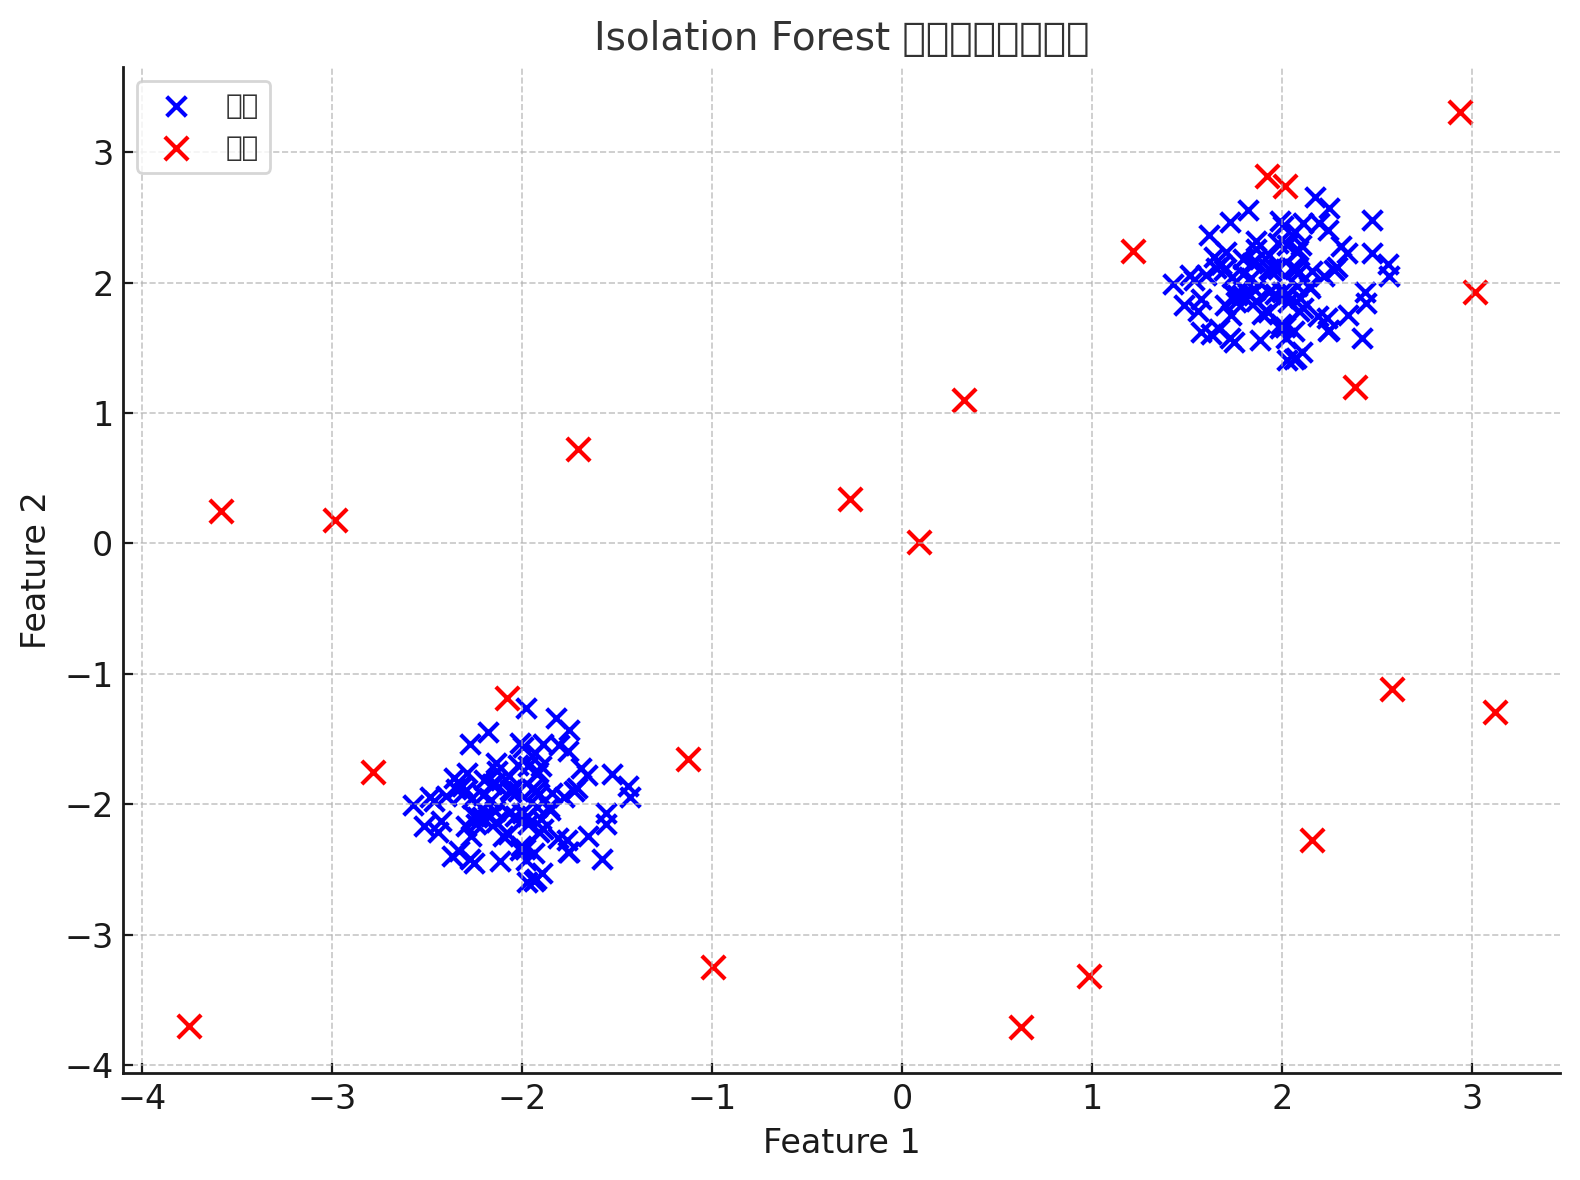

In [16]:
# let's check the results
# Top abnormal performance with high budget
performance[performance['Needs_Improvement']].sort_values(
    by='Avg_Budget', ascending=False
).head(10)

,Month,Role,Person,Project_Count,Avg_Start_Delay,Avg_Completion_Delay,Avg_ACCC_to_Movein,Avg_MO_to_MR,Avg_PCD_to_ACSD,Avg_PCD_to_ACCC,Avg_Budget,Anomaly_Score,Needs_Improvement
405,2022-11,FS,Richard Davis,1,44.0,175.0,39.0,0.0,215.0,175.0,117584.59,-1,True
487,2023-02,FS,Kelly Wagner,1,7.0,58.0,21.0,0.0,91.0,58.0,98312.82,-1,True
767,2023-10,FS,Ashley Caldwell,1,10.0,43.0,70.0,0.0,96.0,43.0,92447.75,-1,True
600,2023-06,FM,Mrs. Kelly Young,1,14.0,80.0,62.0,0.0,118.0,80.0,91047.36,-1,True
614,2023-06,FS,Diane Peterson,1,14.0,80.0,62.0,0.0,118.0,80.0,91047.36,-1,True
138,2021-12,FS,Christine Adams,1,5.0,-85.0,35.0,0.0,335.0,-85.0,88155.44,-1,True
1097,2024-06,FM,Timothy Randall,1,41.0,38.0,49.0,0.0,78.0,38.0,87093.98,-1,True
1115,2024-06,FS,Jay Jones,1,41.0,38.0,49.0,0.0,78.0,38.0,87093.98,-1,True
177,2022-03,FS,Christine Adams,1,12.0,179.0,27.0,0.0,230.0,179.0,86990.30,-1,True
261,2022-07,FS,Chad Carter,1,3.0,141.0,84.0,0.0,165.0,141.0,83535.23,-1,True


In [17]:
# Top abnormal performance with high project count
performance[performance['Needs_Improvement']].sort_values(
    by='Project_Count', ascending=False
)

,Month,Role,Person,Project_Count,Avg_Start_Delay,Avg_Completion_Delay,Avg_ACCC_to_Movein,Avg_MO_to_MR,Avg_PCD_to_ACSD,Avg_PCD_to_ACCC,Avg_Budget,Anomaly_Score,Needs_Improvement
964,2024-03,FM,Angela Medina,17,39.866667,76.866667,79.545455,1.941176,97.733333,76.866667,30143.863529,-1,True
627,2023-06,FS,Richard Davis,13,4.307692,36.769231,32.200000,24.000000,53.538462,36.769231,19410.865385,-1,True
839,2023-12,FM,Angela Medina,13,21.692308,83.230769,98.857143,0.307692,122.153846,83.230769,26892.713846,-1,True
997,2024-03,PC,Lindsey Murphy,12,38.800000,82.000000,56.714286,0.250000,104.600000,82.000000,28053.193333,-1,True
948,2024-02,FS,Maria Morgan,11,17.000000,66.545455,52.000000,1.909091,79.363636,66.545455,14717.635455,-1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,2024-04,FS,Sally Simpson,1,-13.000000,55.000000,67.000000,0.000000,104.000000,55.000000,58437.690000,-1,True
1208,2024-08,FS,Lisa Ortiz,1,76.000000,27.000000,62.000000,0.000000,71.000000,27.000000,0.000000,-1,True
1288,2024-10,FS,Karen Nicholson,1,8.000000,-6.000000,78.000000,0.000000,43.000000,-6.000000,0.000000,-1,True
1327,2024-11,FS,Karen Nicholson,1,41.000000,8.000000,49.000000,0.000000,36.000000,8.000000,0.000000,-1,True


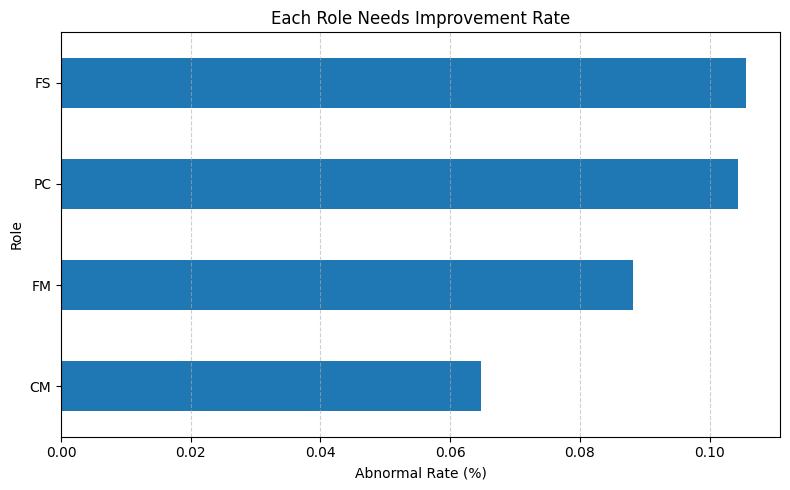

In [18]:
role_summary = performance.groupby('Role')['Needs_Improvement'].mean().sort_values()

plt.figure(figsize=(8, 5))
role_summary.plot(kind='barh')
plt.xlabel('Abnormal Rate (%)')
plt.title('Each Role Needs Improvement Rate')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

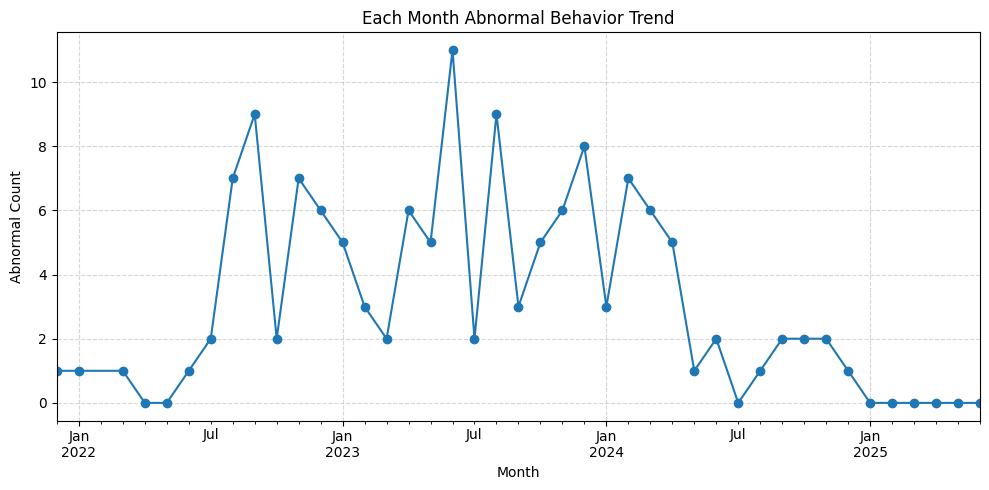

In [19]:
monthly_trend = performance.groupby('Month')['Needs_Improvement'].sum()

plt.figure(figsize=(10, 5))
monthly_trend.plot(marker='o')
plt.ylabel('Abnormal Count')
plt.title('Each Month Abnormal Behavior Trend')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [20]:
# === Step 7.1: detect continuous abnormal for more than 2 months ===
performance['Needs_Improvement'] = performance['Needs_Improvement'].astype(int)

# rank based on people and month
performance = performance.sort_values(by=['Person', 'Role', 'Month'])

# consecutive bad performance
performance['Consecutive_Bad'] = (
    performance.groupby(['Person', 'Role'])['Needs_Improvement']
    .rolling(window=2).sum().reset_index(level=[0,1], drop=True) >= 2
)

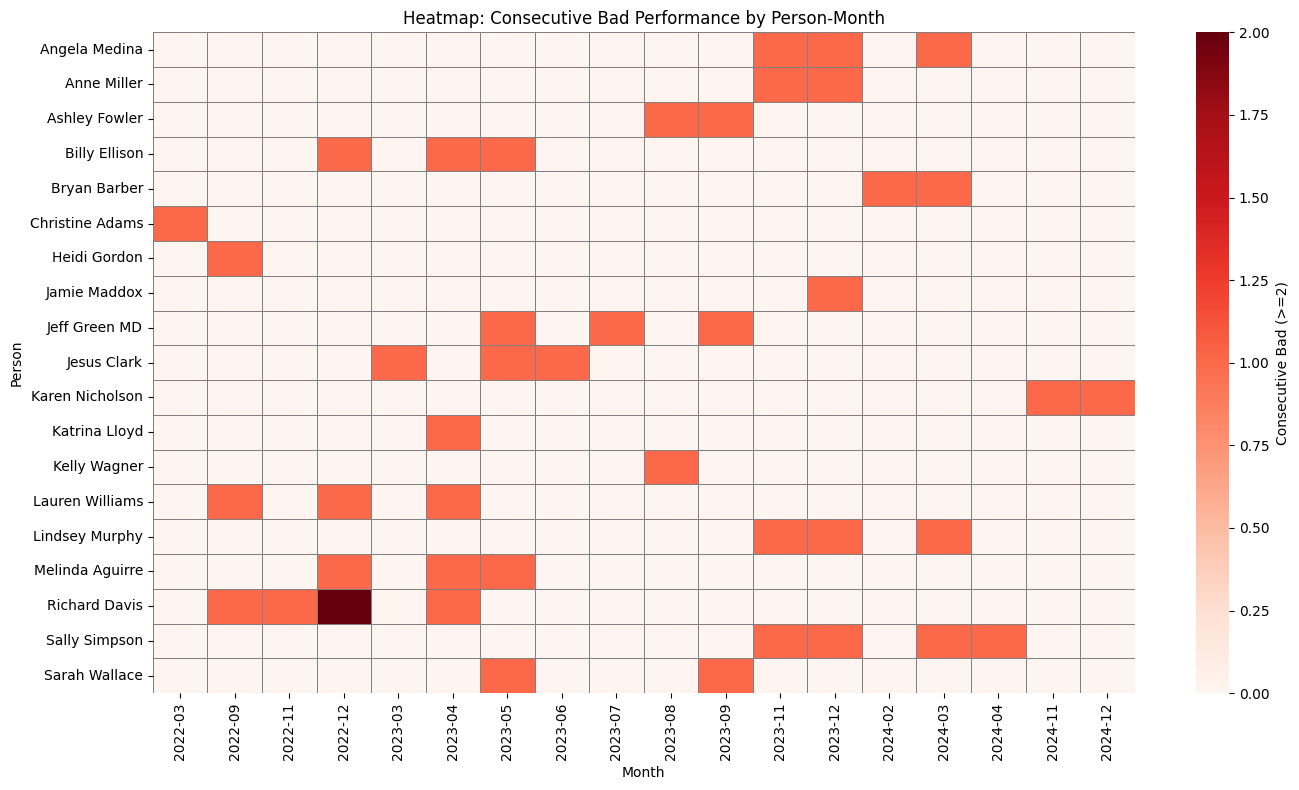

In [21]:
# pivot table to create a person-month-role grid
heatmap_data = (
    performance[performance['Consecutive_Bad']]
    .pivot_table(index='Person', columns='Month', values='Consecutive_Bad', aggfunc='sum', fill_value=0)
)

# plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='Reds', linewidths=0.5, linecolor='grey', cbar_kws={'label': 'Consecutive Bad (>=2)'})
plt.title('Heatmap: Consecutive Bad Performance by Person-Month')
plt.ylabel('Person')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

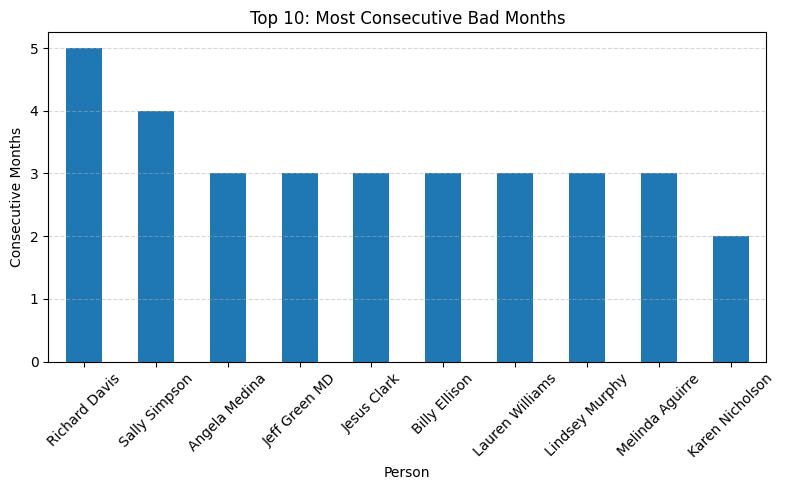

In [22]:
consec_count = performance.groupby('Person')['Consecutive_Bad'].sum().sort_values(ascending=False).head(10)

consec_count.plot(kind='bar', figsize=(8, 5), title='Top 10: Most Consecutive Bad Months', ylabel='Consecutive Months')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

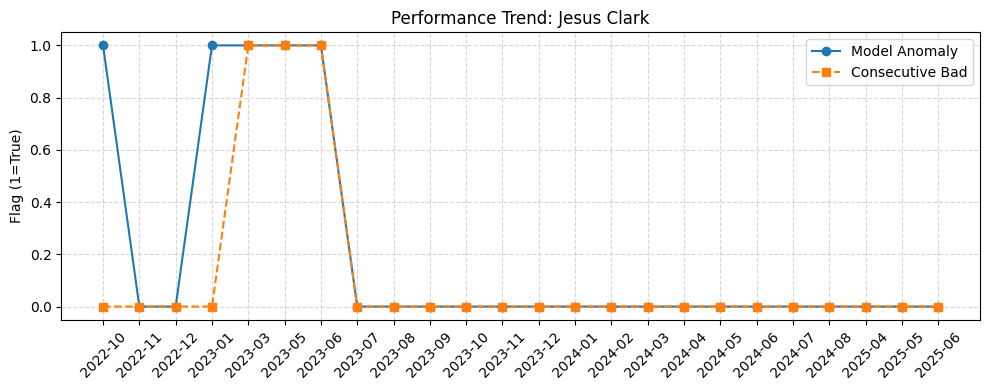

In [23]:
target_person = 'Jesus Clark'  # replace with the person you want to analyze

df_person = performance[performance['Person'] == target_person]

plt.figure(figsize=(10, 4))
plt.plot(df_person['Month'].astype(str), df_person['Needs_Improvement'], marker='o', label='Model Anomaly')
plt.plot(df_person['Month'].astype(str), df_person['Consecutive_Bad'], marker='s', linestyle='--', label='Consecutive Bad')
plt.title(f'Performance Trend: {target_person}')
plt.ylabel('Flag (1=True)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Normalization --> Weighted Score --> Quantile Binning

In [24]:
# Normalize the features for scoring （we use MinMaxScaler to scale the features between 0 and 1）
scaler = MinMaxScaler()
performance[score_features] = scaler.fit_transform(performance[score_features])

# score calculation
performance['Behavior_Score'] = (
    0.15 * performance['Avg_Start_Delay'] +
    0.15 * performance['Avg_Completion_Delay'] +
    0.15 * performance['Avg_ACCC_to_Movein'] +
    0.10 * performance['Avg_MO_to_MR'] +
    0.15 * performance['Avg_PCD_to_ACSD'] +
    0.15 * performance['Avg_PCD_to_ACCC'] +
    0.10 * performance['Avg_Budget']
)

# performance level categorization
performance['Performance_Level'] = pd.qcut(performance['Behavior_Score'], q=4, labels=['excellent', 'good', 'average', 'need improvement'])

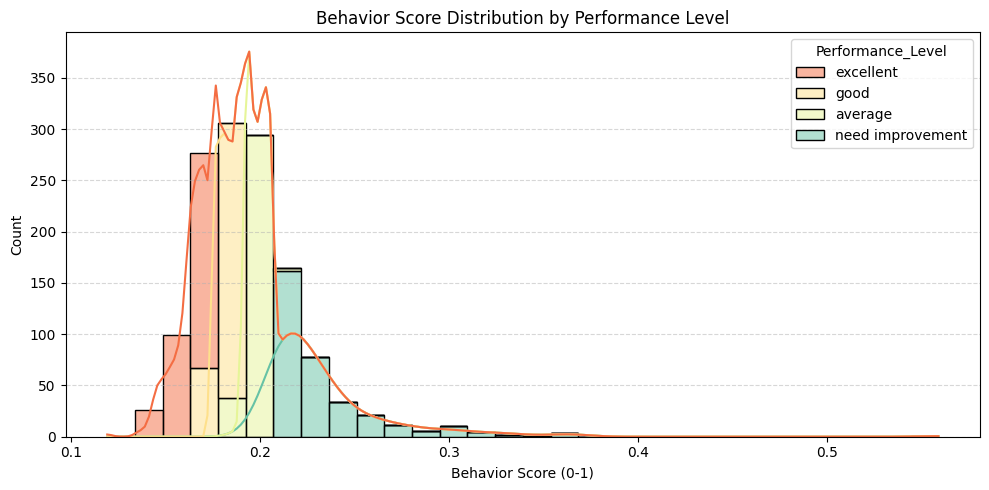

In [25]:
plt.figure(figsize=(10, 5))
sns.histplot(data=performance, x='Behavior_Score', hue='Performance_Level', bins=30, kde=True, palette='Spectral', multiple='stack')
plt.title('Behavior Score Distribution by Performance Level')
plt.xlabel('Behavior Score (0-1)')
plt.ylabel('Count')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

C:\Users\Yijia Wang\AppData\Local\Temp\ipykernel_2096\1011900897.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance.groupby(['Month', 'Performance_Level'])


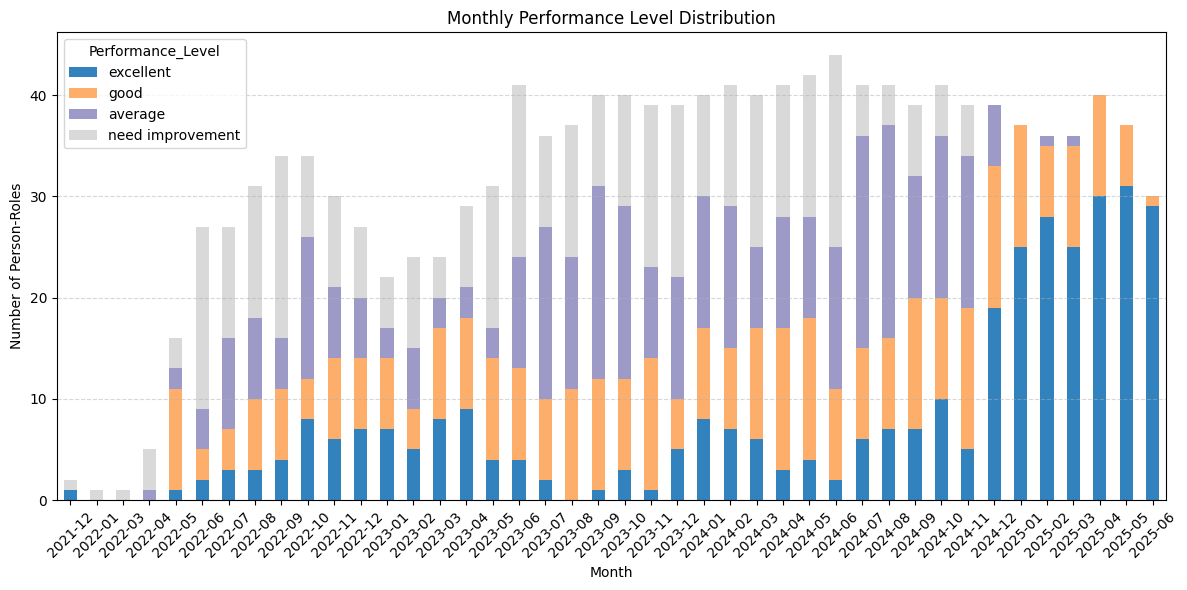

In [26]:
monthly_levels = (
    performance.groupby(['Month', 'Performance_Level'])
    .size()
    .unstack(fill_value=0)
)

monthly_levels.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20c')
plt.title('Monthly Performance Level Distribution')
plt.ylabel('Number of Person-Roles')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

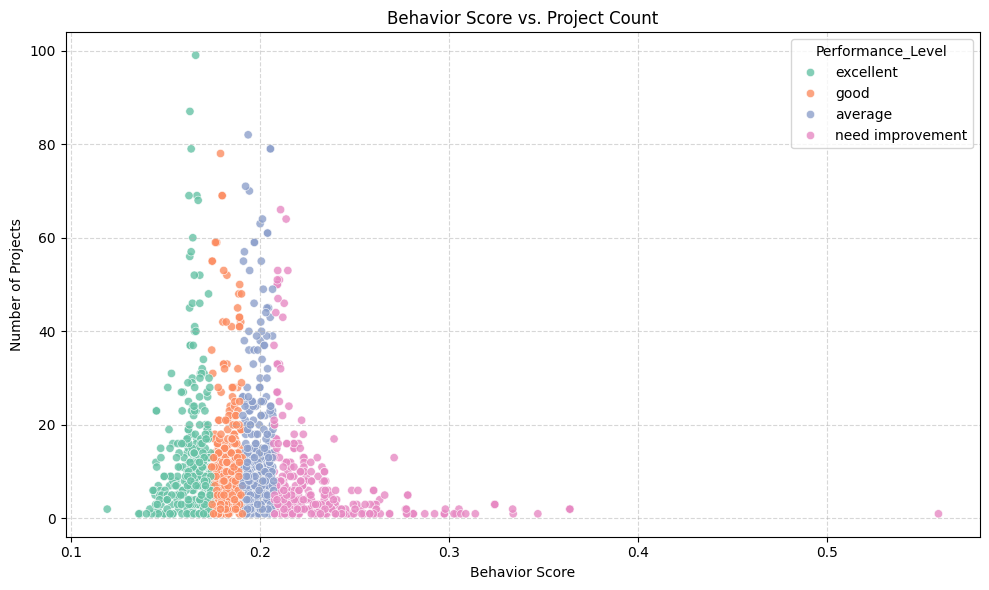

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=performance, x='Behavior_Score', y='Project_Count', hue='Performance_Level', palette='Set2', alpha=0.8)
plt.title('Behavior Score vs. Project Count')
plt.xlabel('Behavior Score')
plt.ylabel('Number of Projects')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

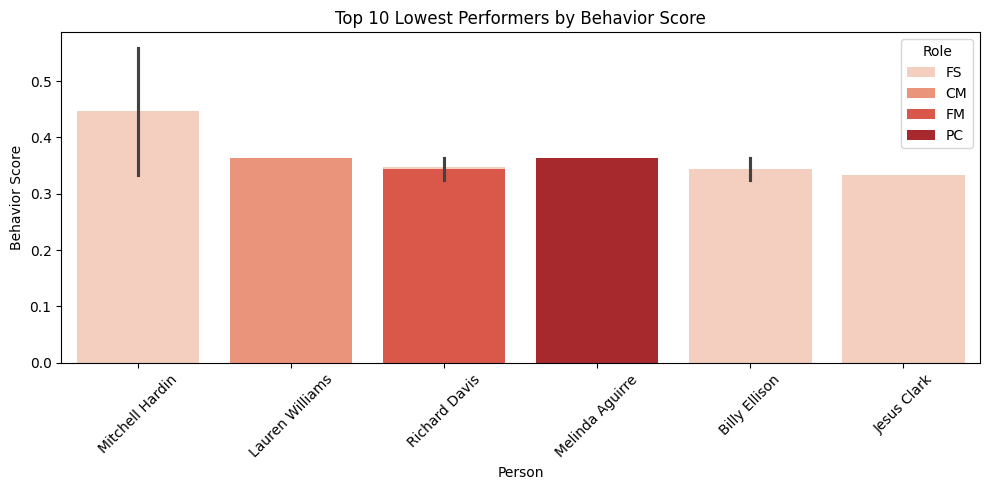

In [28]:
top_bad = performance.sort_values(by='Behavior_Score', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_bad, x='Person', y='Behavior_Score', hue='Role', dodge=False, palette='Reds')
plt.title('Top 10 Lowest Performers by Behavior Score')
plt.xticks(rotation=45)
plt.ylabel('Behavior Score')
plt.tight_layout()
plt.show()


### Every month top and last

In [29]:
# Top 3 every month
top = (
    performance
    .sort_values(['Month', 'Behavior_Score'])
    .groupby(['Month', 'Role'])
    .head(3)
    .assign(Rank='Top Performer')
)

# Bottom 3 every month
bottom = (
    performance
    .sort_values(['Month', 'Behavior_Score'], ascending=False)
    .groupby(['Month', 'Role'])
    .head(3)
    .assign(Rank='Bottom Performer')
)

rank_summary = pd.concat([top, bottom])
rank_summary

,Month,Role,Person,Project_Count,Avg_Start_Delay,Avg_Completion_Delay,Avg_ACCC_to_Movein,Avg_MO_to_MR,Avg_PCD_to_ACSD,Avg_PCD_to_ACCC,Avg_Budget,Anomaly_Score,Needs_Improvement,Consecutive_Bad,Behavior_Score,Performance_Level,Rank
142,2021-12,FS,Morgan Haas,16,0.354421,0.249704,0.156607,0.044271,0.027560,0.249704,0.092208,1,0,False,0.169347,excellent,Top Performer
138,2021-12,FS,Christine Adams,1,0.371590,0.165563,0.039152,0.000000,0.403614,0.165563,0.749719,-1,1,False,0.246794,need improvement,Top Performer
155,2022-01,FS,Mitchell Hardin,1,0.386642,1.000000,0.009788,0.000000,1.000000,1.000000,0.492337,-1,1,False,0.558698,need improvement,Top Performer
177,2022-03,FS,Christine Adams,1,0.397930,0.415326,0.026101,0.000000,0.277108,0.415326,0.739810,-1,1,True,0.303750,need improvement,Top Performer
199,2022-04,FS,Timothy Randall,9,0.361137,0.251866,0.076672,0.000000,0.042570,0.251866,0.462822,1,0,False,0.193899,average,Top Performer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2022-04,FS,Timothy Randall,9,0.361137,0.251866,0.076672,0.000000,0.042570,0.251866,0.462822,1,0,False,0.193899,average,Bottom Performer
177,2022-03,FS,Christine Adams,1,0.397930,0.415326,0.026101,0.000000,0.277108,0.415326,0.739810,-1,1,True,0.303750,need improvement,Bottom Performer
155,2022-01,FS,Mitchell Hardin,1,0.386642,1.000000,0.009788,0.000000,1.000000,1.000000,0.492337,-1,1,False,0.558698,need improvement,Bottom Performer
138,2021-12,FS,Christine Adams,1,0.371590,0.165563,0.039152,0.000000,0.403614,0.165563,0.749719,-1,1,False,0.246794,need improvement,Bottom Performer
